In [26]:
import random
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:

class RangeMinimumQuery:
    def __init__(self):
        self.precompute_all = None
        self.sparse_table = None
        self.block_min = None
        self.block_size = None

    def preprocess_precompute_all(self, array):
        n = len(array)
        self.precompute_all = [[float('inf')] * n for _ in range(n)]
        for i in range(n):
            self.precompute_all[i][i] = array[i]
            for j in range(i + 1, n):
                self.precompute_all[i][j] = min(self.precompute_all[i][j - 1], array[j])

    def query_precompute_all(self, i, j):
        return self.precompute_all[i][j]

    def preprocess_sparse_table(self, array):
        n = len(array)
        log = math.floor(math.log2(n)) + 1
        self.sparse_table = [[float('inf')] * log for _ in range(n)]
        for i in range(n):
            self.sparse_table[i][0] = array[i]
        k = 1
        while (1 << k) <= n:
            for i in range(n - (1 << k) + 1):
                self.sparse_table[i][k] = min(
                    self.sparse_table[i][k - 1],
                    self.sparse_table[i + (1 << (k - 1))][k - 1]
                )
            k += 1

    def query_sparse_table(self, i, j):
        if i > j:
            i, j = j, i
        k = math.floor(math.log2(j - i + 1))
        return min(self.sparse_table[i][k], self.sparse_table[j - (1 << k) + 1][k])

    def preprocess_blocking(self, array):
        n = len(array)
        self.block_size = math.ceil(math.sqrt(n))
        num_blocks = math.ceil(n / self.block_size)
        self.block_min = [float('inf')] * num_blocks
        for k in range(num_blocks):
            start = k * self.block_size
            end = min((k + 1) * self.block_size, n)
            self.block_min[k] = min(array[start:end])

    def query_blocking(self, array, i, j):
        if i > j:
            i, j = j, i
        left_block = i // self.block_size
        right_block = j // self.block_size
        if left_block == right_block:
            return min(array[i:j + 1])
        left_min = min(array[i:(left_block + 1) * self.block_size])
        right_min = min(array[right_block * self.block_size:j + 1])
        if left_block + 1 < right_block:
            middle_min = min(self.block_min[left_block + 1:right_block])
        else:
            middle_min = float('inf')
        return min(left_min, right_min, middle_min)

    def query_precompute_none(self, array, i, j):
        if i > j:
            i, j = j, i
        return min(array[i:j + 1])


def generate_random_array(size):
    return [random.randint(0, 100000) for _ in range(size)]

def generate_sorted_array(size):
    array = generate_random_array(size)
    return sorted(array)

def generate_descending_array(size):
    array = generate_sorted_array(size)
    return array[::-1]

def measure_time(func, *args):
    start_time = time.perf_counter()
    func(*args)
    end_time = time.perf_counter()
    return (end_time - start_time) * 1000

def run_experiment(array, queries, technique, rmq):
    init_time = measure_time(getattr(rmq, f"preprocess_{technique}"), array) if technique != "precompute_none" else 0
    query_time = 0
    for i, j in queries:
        query_time += measure_time(getattr(rmq, f"query_{technique}"), array, i, j) if technique in ["blocking", "precompute_none"] else measure_time(getattr(rmq, f"query_{technique}"), i, j)
    total_time = init_time + query_time
    return init_time, query_time, total_time

def test_varying_query_count(array_size, query_counts):
    array = generate_random_array(array_size)
    rmq = RangeMinimumQuery()
    data = []
    for query_count in query_counts:
        queries = [(random.randint(0, array_size - 1), random.randint(0, array_size - 1)) for _ in range(query_count)]
        for technique in ["precompute_all", "sparse_table", "blocking", "precompute_none"]:
            init_time, query_time, total_time = run_experiment(array, queries, technique, rmq)
            data.append({
                "Technique": technique,
                "Array Size": array_size,
                "Array Type": "Random",
                "Query Count": query_count,
                "Init Time (ms)": init_time,
                "Query Time (ms)": query_time,
                "Total Time (ms)": total_time
            })
    return pd.DataFrame(data)

def test_varying_array_size(query_count, array_sizes):
    rmq = RangeMinimumQuery()
    data = []
    for array_size in array_sizes:
        array = generate_random_array(array_size)
        queries = [(random.randint(0, array_size - 1), random.randint(0, array_size - 1)) for _ in range(query_count)]
        for technique in ["precompute_all", "sparse_table", "blocking", "precompute_none"]:
            init_time, query_time, total_time = run_experiment(array, queries, technique, rmq)
            data.append({
                "Technique": technique,
                "Array Size": array_size,
                "Array Type": "Random",
                "Query Count": query_count,
                "Init Time (ms)": init_time,
                "Query Time (ms)": query_time,
                "Total Time (ms)": total_time
            })
    return pd.DataFrame(data)

def test_varying_array_types(array_size, query_count):
    rmq = RangeMinimumQuery()
    data = []
    arrays = {
        "Random": generate_random_array(array_size),
        "Sorted": generate_sorted_array(array_size),
        "Descending": generate_descending_array(array_size),
    }
    queries = [(random.randint(0, array_size - 1), random.randint(0, array_size - 1)) for _ in range(query_count)]
    for array_type, array in arrays.items():
        for technique in ["precompute_all", "sparse_table", "blocking", "precompute_none"]:
            init_time, query_time, total_time = run_experiment(array, queries, technique, rmq)
            data.append({
                "Technique": technique,
                "Array Size": array_size,
                "Query Count": query_count,
                "Array Type": array_type,
                "Init Time (ms)": init_time,
                "Query Time (ms)": query_time,
                "Total Time (ms)": total_time
            })
    return pd.DataFrame(data)

In [28]:
df_query_count = test_varying_query_count(1000, [1, 10, 100, 1000, 10000])
df_array_size = test_varying_array_size(1000000, [100, 1000, 10000, 10000])
df_array_types = test_varying_array_types(10000, 1000)

In [47]:
df_array_size

,Technique,Array Size,Array Type,Query Count,Init Time (ms),Query Time (ms),Total Time (ms)
0,precompute_all,100,Random,1000000,0.6728,140.434400,141.107200
1,sparse_table,100,Random,1000000,0.1367,379.702399,379.839099
2,blocking,100,Random,1000000,0.0185,869.911201,869.929701
3,precompute_none,100,Random,1000000,0.0000,649.273001,649.273001
4,precompute_all,1000,Random,1000000,73.0350,243.192100,316.227100
5,sparse_table,1000,Random,1000000,2.1658,417.371200,419.537000
6,blocking,1000,Random,1000000,0.0351,1269.401500,1269.436600
7,precompute_none,1000,Random,1000000,0.0000,3654.019400,3654.019400
8,precompute_all,10000,Random,1000000,9009.3696,428.071699,9437.441299
9,sparse_table,10000,Random,1000000,97.2762,579.625200,676.901400


In [30]:
df_query_count

,Technique,Array Size,Array Type,Query Count,Init Time (ms),Query Time (ms),Total Time (ms)
0,precompute_all,1000,Random,1,74.8628,0.0022,74.8650
1,sparse_table,1000,Random,1,2.5338,0.0052,2.5390
2,blocking,1000,Random,1,0.0295,0.0041,0.0336
3,precompute_none,1000,Random,1,0.0000,0.0070,0.0070
4,precompute_all,1000,Random,10,78.3840,0.0098,78.3938
5,sparse_table,1000,Random,10,2.3122,0.0117,2.3239
6,blocking,1000,Random,10,0.0293,0.0226,0.0519
7,precompute_none,1000,Random,10,0.0000,0.0391,0.0391
8,precompute_all,1000,Random,100,75.6375,0.0482,75.6857
9,sparse_table,1000,Random,100,2.2879,0.0483,2.3362


In [31]:
df_array_types

,Technique,Array Size,Query Count,Array Type,Init Time (ms),Query Time (ms),Total Time (ms)
0,precompute_all,10000,1000,Random,7566.7063,0.5611,7567.2674
1,sparse_table,10000,1000,Random,172.2193,0.4574,172.6767
2,blocking,10000,1000,Random,0.1633,2.3479,2.5112
3,precompute_none,10000,1000,Random,0.0000,33.5680,33.5680
4,precompute_all,10000,1000,Sorted,7884.6710,0.6381,7885.3091
5,sparse_table,10000,1000,Sorted,73.4783,0.4608,73.9391
6,blocking,10000,1000,Sorted,0.1444,2.2715,2.4159
7,precompute_none,10000,1000,Sorted,0.0000,38.5586,38.5586
8,precompute_all,10000,1000,Descending,8193.6080,0.5974,8194.2054
9,sparse_table,10000,1000,Descending,426.2023,0.4560,426.6583


In [32]:
def visualize_results_as_line(df, x="Array Size", y="Total Time (ms)"):
    sns.lineplot(data=df, x=x, y=y, hue="Technique", marker="o")
    plt.title(f"{y} vs {x}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)
    plt.legend(title="Technique")
    plt.show()


In [33]:
def visualize_results_as_bar(df, x="Array Type", y="Total Time (ms)"):
    sns.barplot(data=df, x=x, y=y, hue="Technique")
    plt.title(f"{y} by Array Type")
    plt.xlabel("Array Type")
    plt.ylabel(y)
    plt.grid(axis='y')
    plt.legend(title="Technique")
    plt.show()


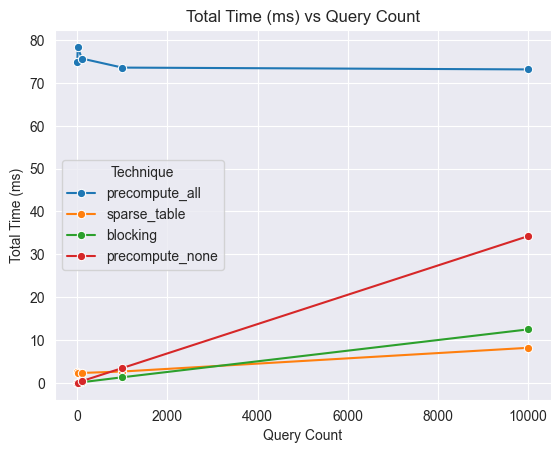

In [34]:
visualize_results_as_line(df_query_count, x= "Query Count")

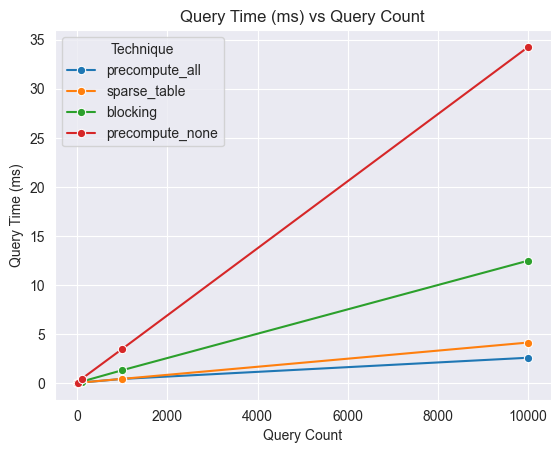

In [39]:
visualize_results_as_line(df_query_count, x= "Query Count", y= "Query Time (ms)")

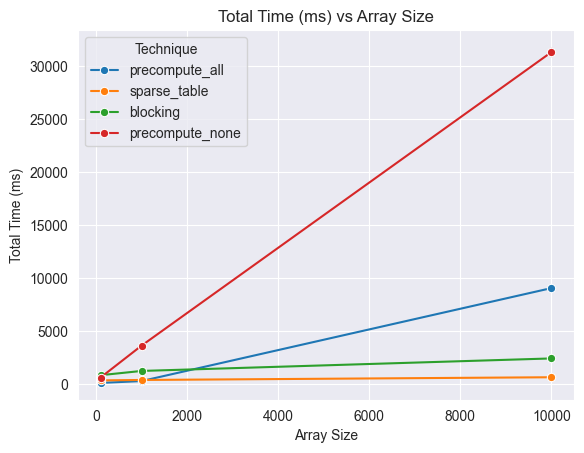

In [35]:
visualize_results_as_line(df_array_size)

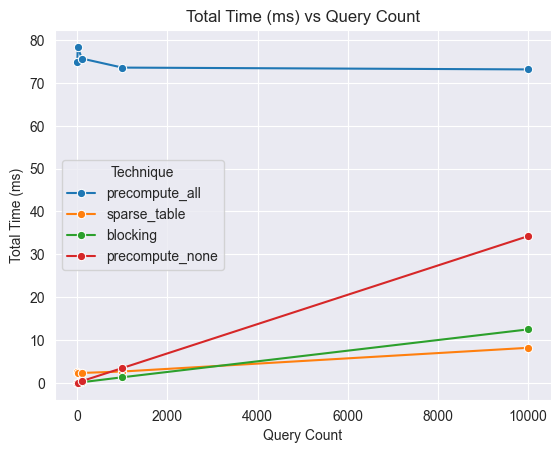

In [74]:
visualize_results_as_line(df_query_count, x="Query Count", y="Total Time (ms)")

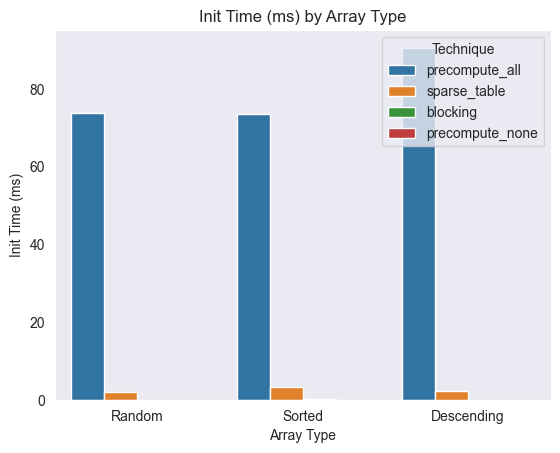

In [54]:
df_array_types = test_varying_array_types(1000, 100000)
visualize_results_as_bar(df_array_types,  y="Init Time (ms)")

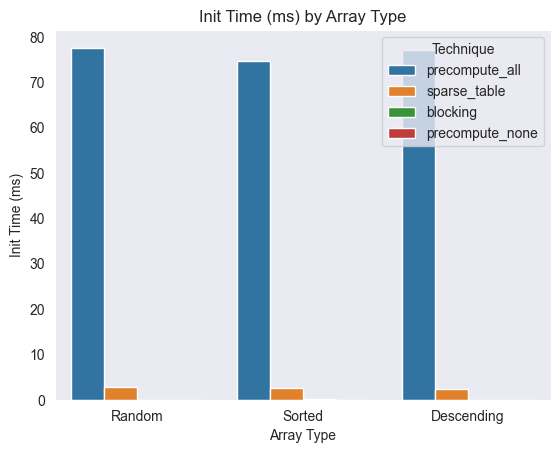

In [55]:
df_array_types = test_varying_array_types(1000, 10000)
visualize_results_as_bar(df_array_types,  y="Init Time (ms)")

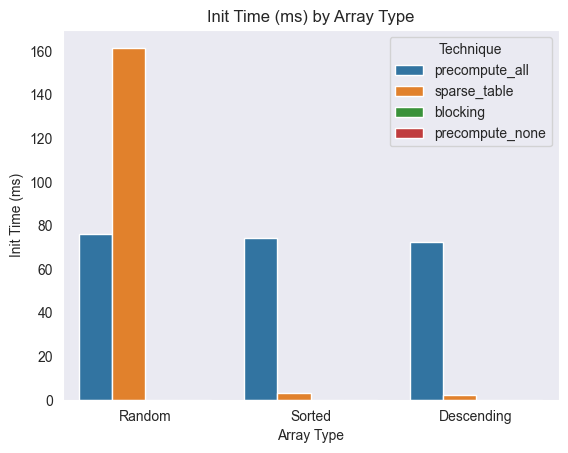

In [56]:
df_array_types = test_varying_array_types(1000, 1000)
visualize_results_as_bar(df_array_types, y="Init Time (ms)")

In [59]:
def test_varying_array_types_avg(array_size, query_count, runs=10):
    all_data = []
    for _ in range(runs):
        df = test_varying_array_types(array_size, query_count)
        print(f"run {_ + 1}")
        all_data.append(df)
    combined_data = pd.concat(all_data)
    avg_data = combined_data.groupby(["Technique", "Array Type"], as_index=False).mean()
    return avg_data

run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10


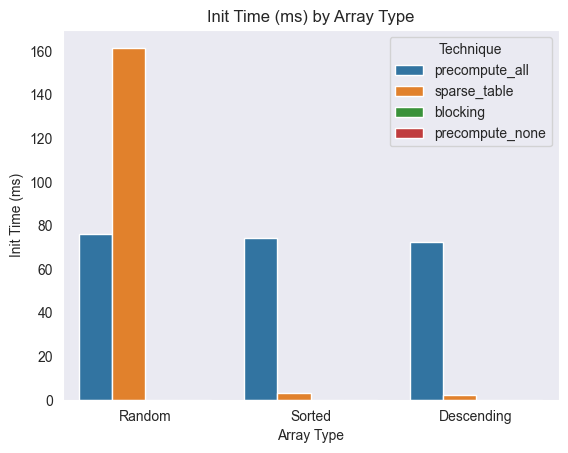

In [60]:
df_array_types_avg = test_varying_array_types_avg(10000, 1000, runs=10)
visualize_results_as_bar(df_array_types, y="Init Time (ms)")

In [61]:
df_array_types_avg

,Technique,Array Type,Array Size,Query Count,Init Time (ms),Query Time (ms),Total Time (ms)
0,blocking,Descending,10000.0,1000.0,0.15705,2.42395,2.58100
1,blocking,Random,10000.0,1000.0,0.20156,2.53903,2.74059
2,blocking,Sorted,10000.0,1000.0,0.16430,2.33531,2.49961
3,precompute_all,Descending,10000.0,1000.0,8235.80346,0.59080,8236.39426
4,precompute_all,Random,10000.0,1000.0,7898.82459,0.61696,7899.44155
5,precompute_all,Sorted,10000.0,1000.0,8597.66437,0.61130,8598.27567
6,precompute_none,Descending,10000.0,1000.0,0.00000,38.48548,38.48548
7,precompute_none,Random,10000.0,1000.0,0.00000,36.66640,36.66640
8,precompute_none,Sorted,10000.0,1000.0,0.00000,39.90857,39.90857
9,sparse_table,Descending,10000.0,1000.0,194.34910,0.48798,194.83708


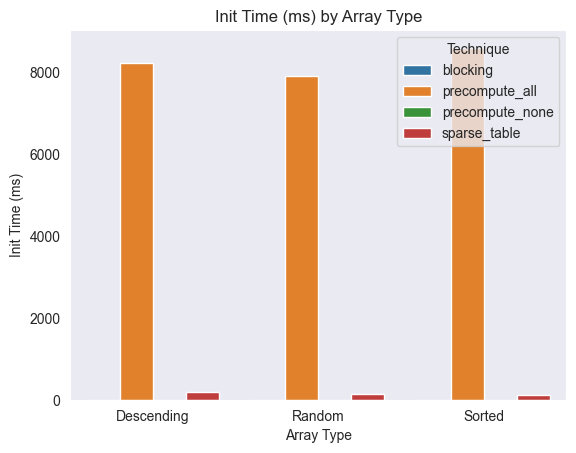

In [62]:
visualize_results_as_bar(df_array_types_avg, y="Init Time (ms)")

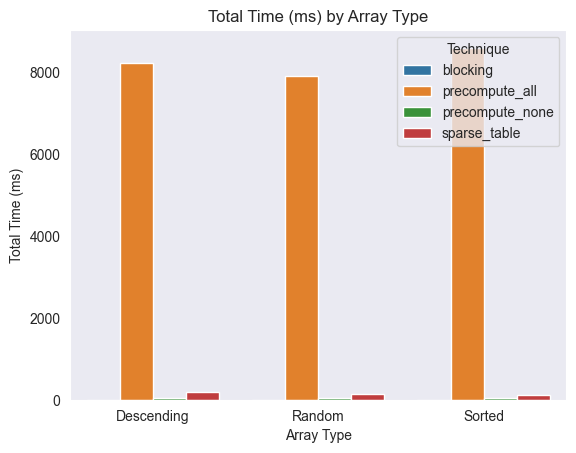

In [63]:
visualize_results_as_bar(df_array_types_avg)

In [64]:
def plot_pie_chart_ratios(df, title_prefix):
    techniques = df['Technique'].unique()

    for technique in techniques:
        # Filter data for the current technique
        data = df[df['Technique'] == technique]
        if data.empty:
            continue

        # Sum initialization and query times across rows for the technique
        init_time = data['Init Time (ms)'].sum()
        query_time = data['Query Time (ms)'].sum()

        # Calculate percentages
        total_time = init_time + query_time
        ratios = [init_time / total_time * 100, query_time / total_time * 100]
        labels = ['Initialization Time', 'Query Time']
        colors = ['#1f77b4', '#ff7f0e']

        # Plot pie chart
        plt.figure(figsize=(6, 6))
        plt.pie(ratios, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
        plt.title(f"{title_prefix} - {technique.capitalize()} Technique")
        plt.axis('equal')
        plt.show()

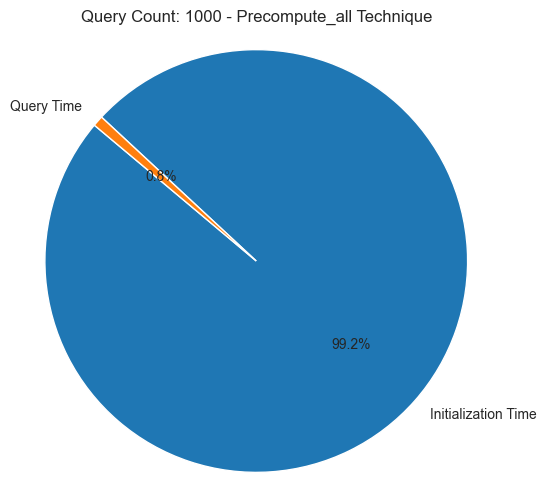

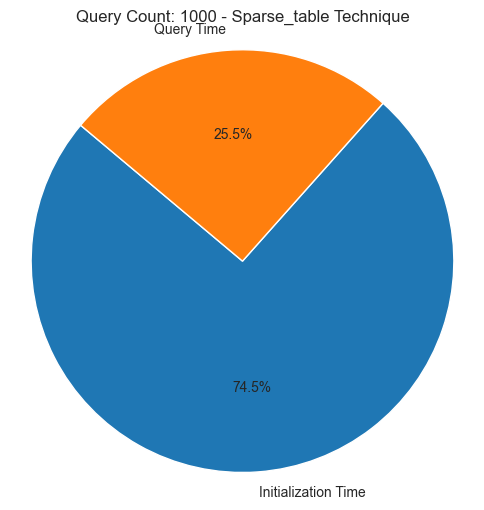

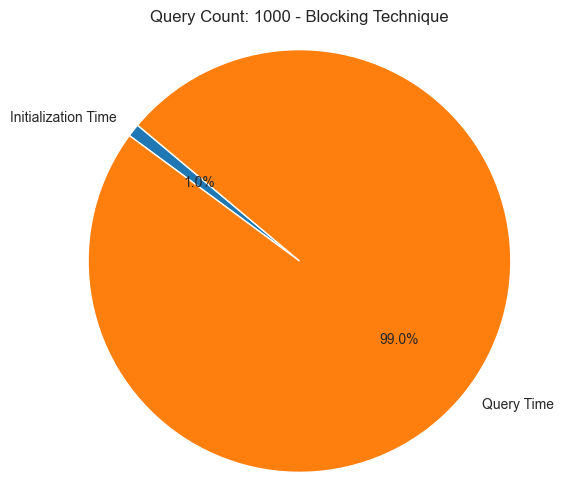

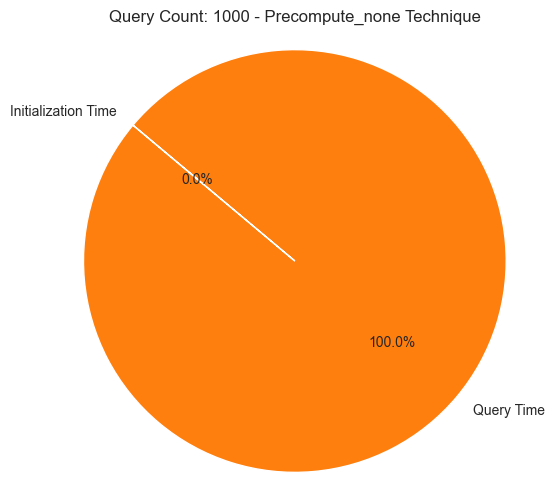

In [66]:
plot_pie_chart_ratios(df_query_count, "Query Count: 1000")

In [79]:
precompute_all_df = df_array_types[df_array_types["Technique"] == "sparse_table"]
precompute_all_df

,Technique,Array Size,Query Count,Array Type,Init Time (ms),Query Time (ms),Total Time (ms)
1,sparse_table,1000,1000,Random,161.5345,0.6253,162.1598
5,sparse_table,1000,1000,Sorted,2.8568,0.4239,3.2807
9,sparse_table,1000,1000,Descending,2.2946,0.4158,2.7104


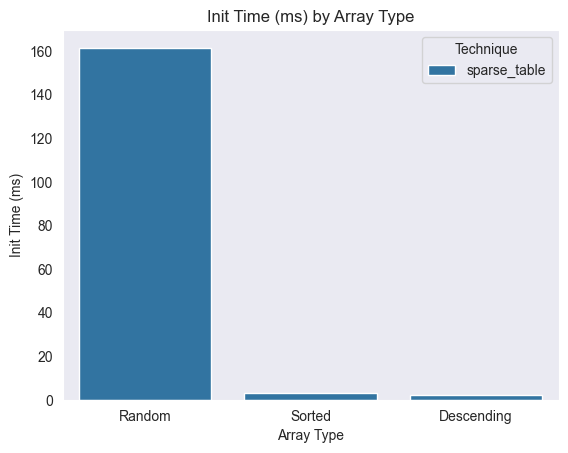

In [78]:
precompute_all_df = df_array_types[df_array_types["Technique"] == "sparse_table"]
visualize_results_as_bar(precompute_all_df, x="Array Type", y="Init Time (ms)")

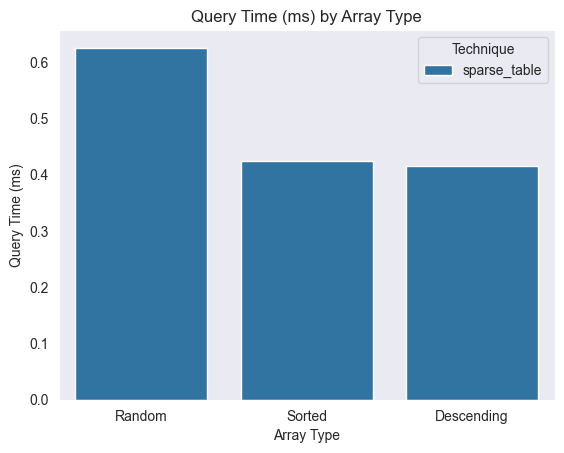

In [76]:
precompute_all_df = df_array_types[df_array_types["Technique"] == "sparse_table"]
visualize_results_as_bar(precompute_all_df, x="Array Type", y="Query Time (ms)")

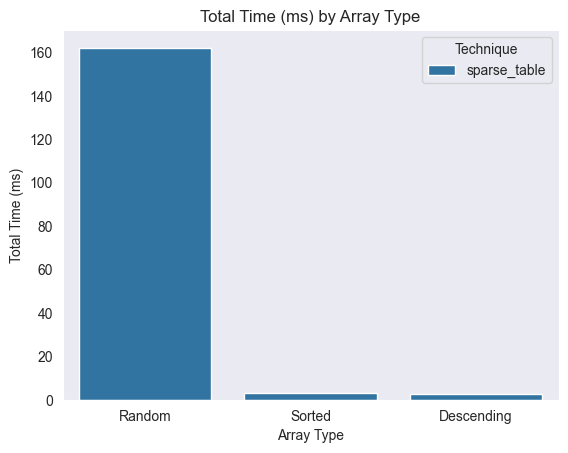

In [77]:
precompute_all_df = df_array_types[df_array_types["Technique"] == "sparse_table"]
visualize_results_as_bar(precompute_all_df, x="Array Type", y="Total Time (ms)")

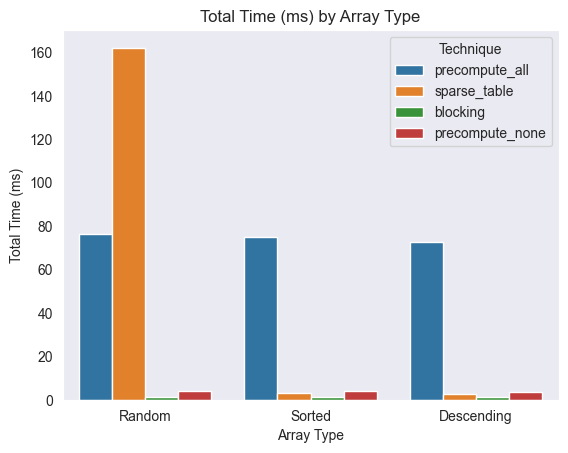

In [80]:
visualize_results_as_bar(df_array_types, y="Total Time (ms)")

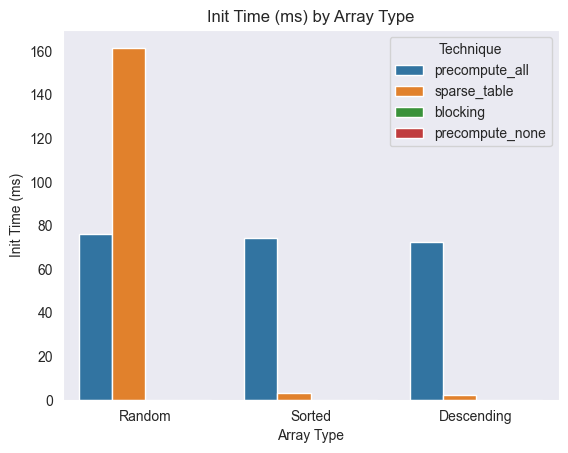

In [81]:
visualize_results_as_bar(df_array_types, y="Init Time (ms)")

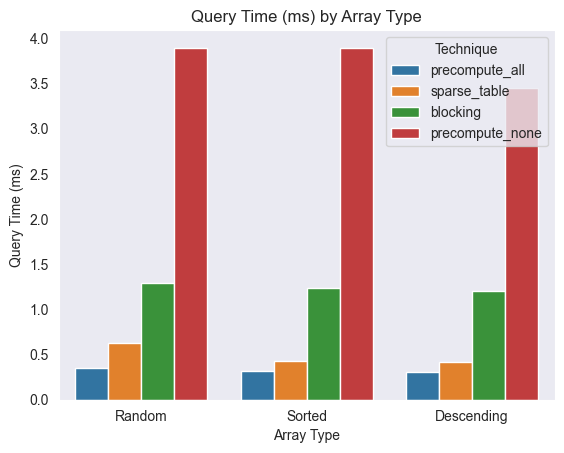

In [82]:
visualize_results_as_bar(df_array_types, y="Query Time (ms)")